# Interview Segmentation

In this notebook I analyse the results of applying a raw-audio gender recognition model to an Kirsty Wark and Sir Elton John.


The interview can be found here https://www.youtube.com/watch?v=nogZ4TZhHrU

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import jaccard_similarity_score

# added: jaccard_similarity_score is deprecated and sklearn has told, it can have strange behaviours 
from sklearn.metrics import jaccard_score

In [2]:
df = pd.read_csv('../data/results.csv')

In [3]:
step_seconds = df['second'].values[1]-df['second'].values[0]

In [4]:
df

,minute,p,second,t_center,t_end,t_start
0,0.000000,0.000549,0.00,1.50,3.00,0.00
1,0.000667,0.000438,0.04,1.54,3.04,0.04
2,0.001333,0.000227,0.08,1.58,3.08,0.08
3,0.002000,0.000314,0.12,1.62,3.12,0.12
4,0.002667,0.000267,0.16,1.66,3.16,0.16
...,...,...,...,...,...,...
12763,8.508667,0.016294,30.52,512.02,513.52,510.52
12764,8.509333,0.013098,30.56,512.06,513.56,510.56
12765,8.510000,0.028885,30.60,512.10,513.60,510.60
12766,8.510667,0.302075,30.64,512.14,513.64,510.64


### Plot raw predictions

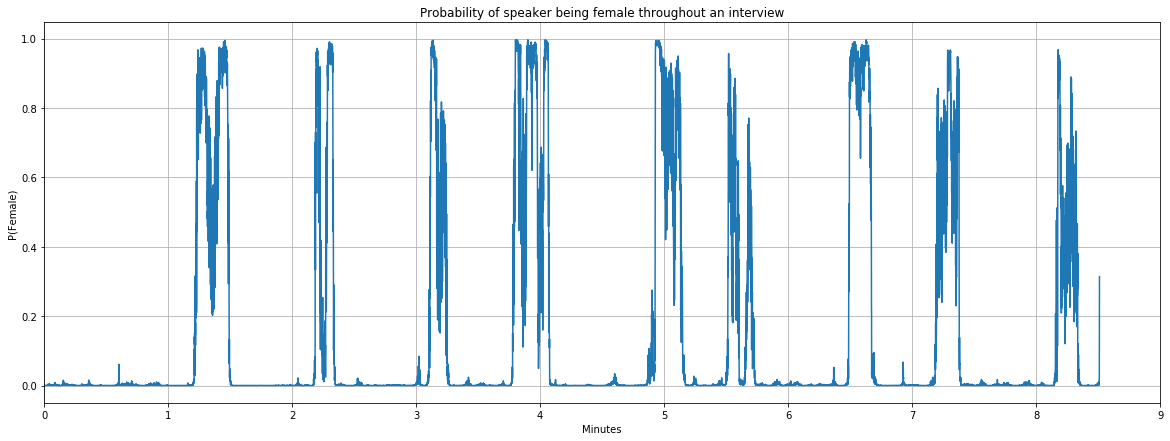

In [5]:
plt.figure(figsize=(20,7))
plt.title('Probability of speaker being female throughout an interview')
plt.plot(
    df['minute'],
    df['p']
)
plt.xlabel('Minutes')
plt.xticks(range(11))
plt.xlim((0,9))
plt.ylabel('P(Female)')
plt.grid()
plt.show()

In [6]:
df = df.assign(
    p_smoothed_2500ms=df['p'].rolling(window=50,center=True).mean(),
    p_smoothed_1000ms=df['p'].rolling(window=20,center=True).mean(),
)

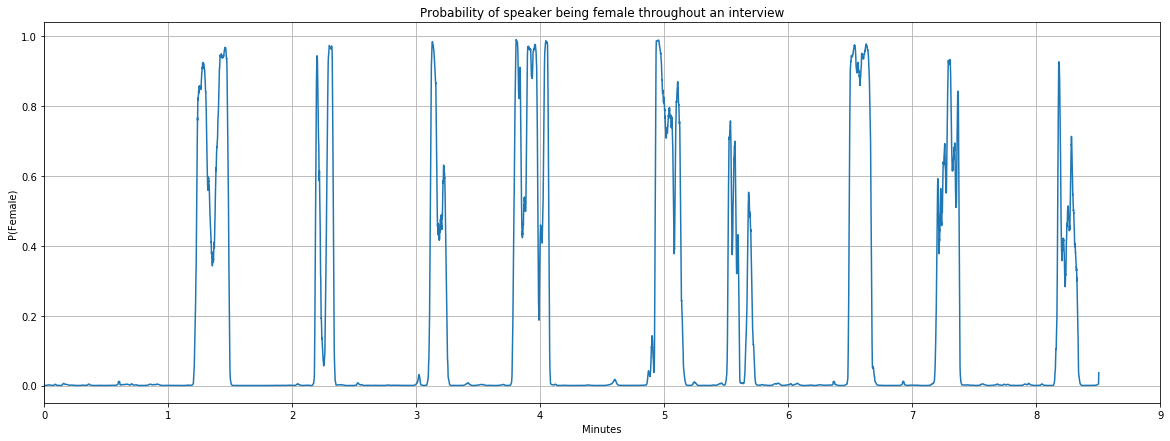

In [8]:
plt.figure(figsize=(20,7))
plt.title('Probability of speaker being female throughout an interview')
# plt.plot(
#     df['minute'],
#     df['p_smoothed_2500ms']
# )
plt.plot(
    df['minute'],
    df['p_smoothed_1000ms']
)
plt.xlabel('Minutes')
plt.xticks(range(11))
plt.xlim((0,9))
plt.ylabel('P(Female)')
plt.grid()
plt.show()

### Process data into start and stop times for each speaker
Manually curated start/stop/interruption times below.

In [9]:
# This list of tuples represents each time in seconds the inteviewer Kirsty Wark starts and stops speaking
kirsty_start_stop = [
    (74,91),  
    (132,141),  
    (188,192),  
    (193,197),
    (228,245), 
    (293,295),  
    (297,308),
    (332,336),
    (339,340),
    (342,344),
    (390,402),
    (432,445),
    (491,502)
]
elton_john_interjections = [
    84,   # "No" (very quiet)
    136,  # "Ughh"
    138,  # "Yeah"
    192,  # "Yeah"
    232,  # *Laughs*
    233,  # "Yeah"
    241,  # "Oh my god"
    242,  # "Yeah"
    307,  # "Of course"
    334,  # "Yeah"
    335,  # "Well stop using them"
    339,  # "Boycott them"
    437,  # "Nah"
]

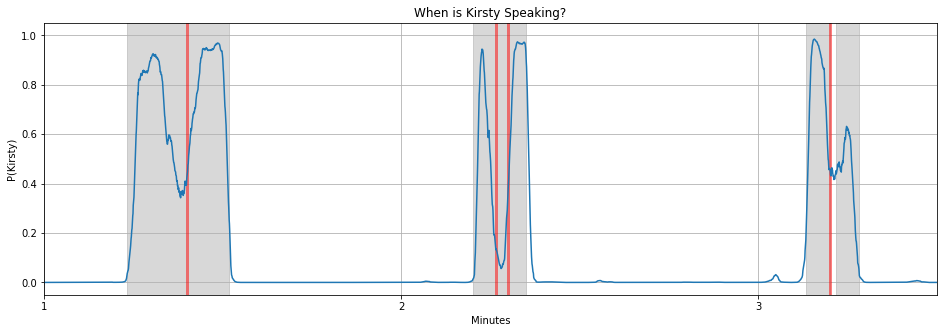

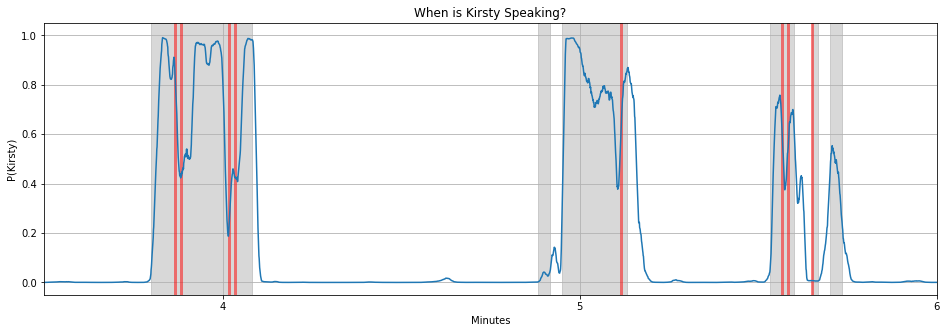

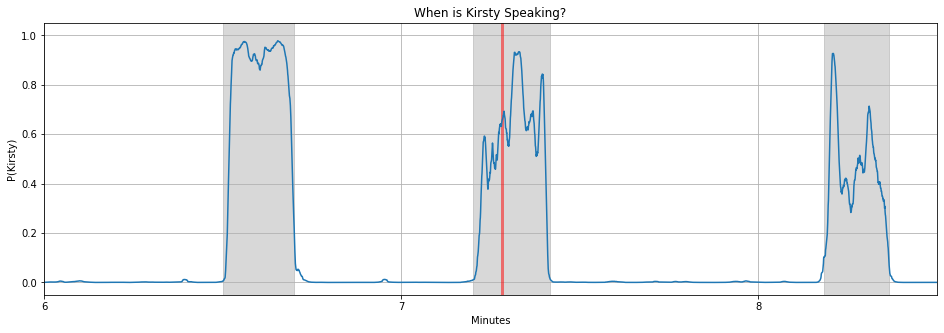

In [10]:
for start_minute in np.arange(1,8,2.5):
    plt.figure(figsize=(16,5))
    plt.title('When is Kirsty Speaking?')

    # Plot smoothed probabilities
    plt.plot(
        df['t_center']/60.,
        df['p_smoothed_1000ms'],
    )

    # Plot manual Kirsty start and stop times
    for kirsty_start_s, kirsty_stop_s in kirsty_start_stop:
        plt.fill_betweenx(
            x1=kirsty_start_s/60.,
            x2=kirsty_stop_s/60.,
            y=(-1,2),
            alpha=0.3,
            color='gray'
        )

    # Plot Elton's interjections
    plt.vlines(np.array(elton_john_interjections)/60.,-1,2,colors='r',linewidth=3,alpha=0.5)

    # Formatting
    plt.xlabel('Minutes')
    plt.xticks(range(11))
    plt.xlim((start_minute,start_minute+2.5))
    plt.ylim((-0.05,1.05))
    plt.ylabel('P(Kirsty)')
    plt.grid()
    plt.show()

In [11]:
y_true = np.zeros(len(df))

for kirsty_start_s, kirsty_stop_s in kirsty_start_stop:
    kirsty_start_idx = int(kirsty_start_s/step_seconds)
    kirsty_stop_idx = int(kirsty_stop_s/step_seconds)
    y_true[kirsty_start_idx:kirsty_stop_idx] = 1

In [22]:
jaccard_similarity_score(y_true, (df['p'].values > 0.5))

0.9109492481203008

In [29]:
# added
jaccard_score(y_true, (df['p'].values > 0.5))

0.6016117729502453

In [24]:
jaccard_similarity_score(y_true, (df['p_smoothed_1000ms'].bfill().ffill().values > 0.5))

0.9113408521303258

In [30]:
# added
jaccard_score(y_true, (df['p_smoothed_1000ms'].bfill().ffill().values > 0.5))

0.6008462623413258

### Added

**FutureWarning** : jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)

In [54]:
( y_true == (df['p'].values > 0.5) ).sum() / y_true.size

0.9109492481203008

In [53]:
( y_true == (df['p_smoothed_1000ms'].bfill().ffill().values > 0.5) ).sum() / y_true.size

0.9113408521303258

Comments:
1. Model definitely has a strong bias towards predicting a male voice. 
    * P(female) rarely reaches 1 even when Kirsty talks uninterrupted
    * Segments which contain both speakers favour Elton
    * This could be due to the fact that 51.7% of samples in the training set are male
2. Model failure at 8m30s as the model concludes that Elton is talking even though Kirsty talks uninterrupted during this period

# Determine best threshold and smoothing by Intersection-over-Union
We're doing 1D segmentation so IoU is an appropriate metric.

Smoothing values: Rolling mean from 50ms (no smoothing) to 3000ms (window length).

In [39]:
results = []
for smoothing in tqdm(range(50,3001,50)):
    if smoothing == 50:
        y_pred = df['p'].values
    else:
        y_pred = df['p'].rolling(window=smoothing//50,center=True).mean().bfill().ffill()
    
    # Not gonna search high thresholds as I can already see these are quite bad
    for threshold in np.arange(0,0.51,0.005):
        results.append({
            'smoothing': smoothing,
            'threshold': threshold,
            'iou': jaccard_similarity_score(y_true, (y_pred > threshold)),
            'iou_new': jaccard_score(y_true, (y_pred > threshold))
        })
        
results = pd.DataFrame(results).sort_values('iou',ascending=False)

# // added in window=smoothing//50

C:\Users\Arnau\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [40]:
results.head(5)

,smoothing,threshold,iou,iou_new
1743,900,0.045,0.949561,0.793590
2965,1500,0.035,0.949561,0.797357
2761,1400,0.035,0.949405,0.796407
1948,1000,0.050,0.949405,0.792749
1744,900,0.050,0.949405,0.792416


In [41]:
best_threshold, best_smoothing = tuple(results[['threshold','smoothing']].values[0])
best_threshold, best_smoothing

(0.045, 900.0)

The fact that this grid search chooes such a small threshold is indicative of the male bias in this model.

### Plot using these values

In [42]:
def sigmoid(x):
    return 1./(1 + np.exp(-x))

def logit(x):
    return np.log(x/(1-x))

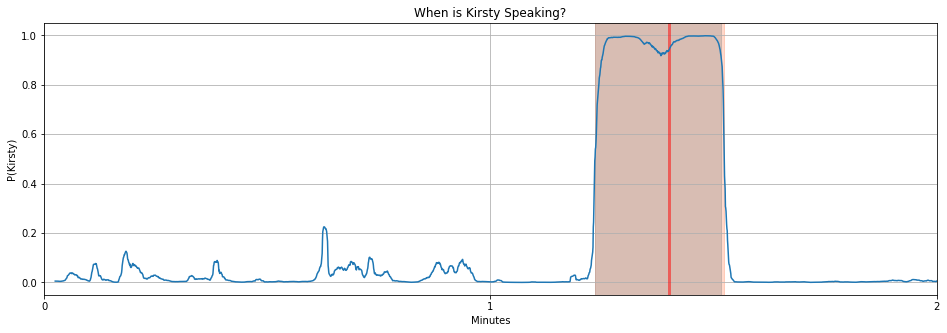

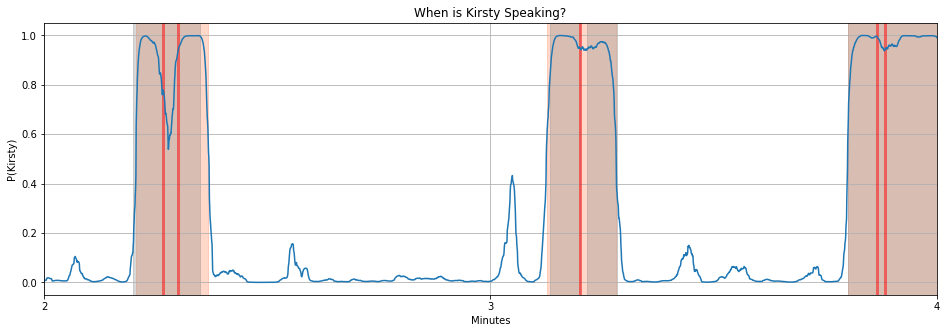

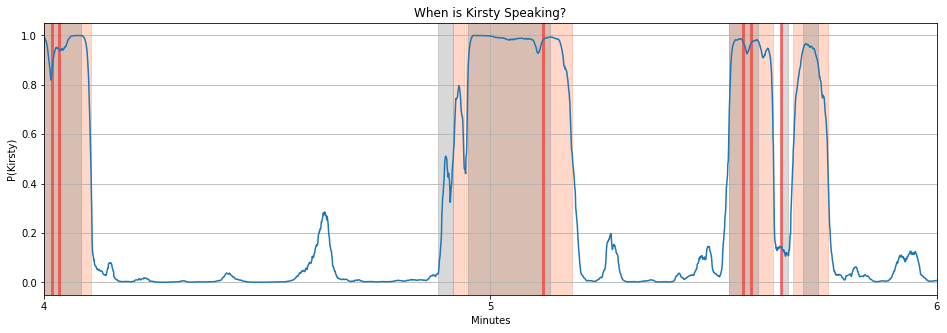

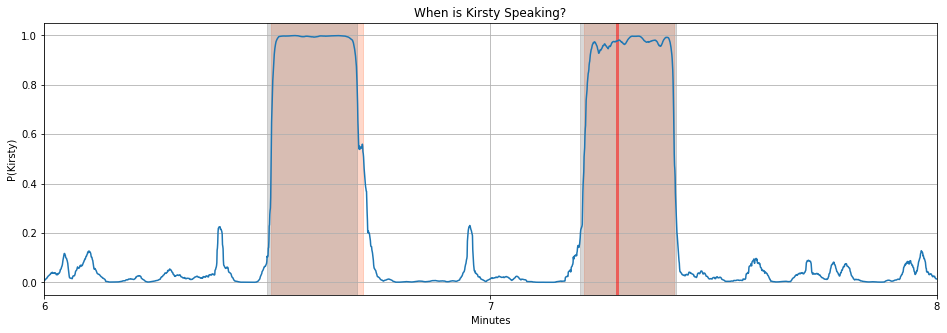

In [43]:
minute_step_size = 2.
for start_minute in np.arange(0,8,minute_step_size):
    plt.figure(figsize=(16,5))
    plt.title('When is Kirsty Speaking?')

    # Plot smoothed probabilities
    p = df['p'].rolling(window=int(best_smoothing/50),center=True).mean().bfill()
    plt.plot(
        df['t_center']/60.,
#         p,
        sigmoid(logit(p)-np.log(best_threshold))  # Rescale probabilities so the chosen threshold becomes 0.5
    )
    
    # Plot predicted Kirsty start and stop times
    plt.fill_between(
        df['t_center']/60.,
        -1, 2,
        where=p > best_threshold,
        color='coral',
        alpha=0.3
    )
    # Plot manual Kirsty start and stop times
    for kirsty_start_s, kirsty_stop_s in kirsty_start_stop:
        plt.fill_betweenx(
            x1=kirsty_start_s/60.,
            x2=kirsty_stop_s/60.,
            y=(-1,2),
            alpha=0.3,
            color='gray'
        )
    
    # Plot Elton's interjections
    plt.vlines(np.array(elton_john_interjections)/60.,-1,2,colors='r',linewidth=3,alpha=0.5)

    # Formatting
    plt.xlabel('Minutes')
    plt.xticks(range(11))
    plt.xlim((start_minute,start_minute+minute_step_size))
    plt.ylim((-0.05,1.05))
    plt.ylabel('P(Kirsty)')
    plt.grid()
    plt.show()
    